# Fine-Tuning a Sentence Transformer for Address Matching

This notebook fine-tunes a `SentenceTransformer` model to match addresses efficiently via cosine similarity.

In [1]:
import json
import logging
import os
import random
import re
import sys
import time
import warnings
from numbers import Number
from typing import Callable, Dict, List, Literal, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pytest
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from datasets import Dataset
from fuzzywuzzy import fuzz

from postal.parser import parse_address
from scipy.spatial import distance
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sentence_transformers import InputExample, SentenceTransformer, SentencesDataset, SentenceTransformerTrainer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction, BinaryClassificationEvaluator
from sentence_transformers.model_card import SentenceTransformerModelCardData
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments
from tenacity import retry
from torch.utils.data import DataLoader
from torch.optim import RAdam
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.integrations import WandbCallback

from utils import (
    augment_gold_labels,
    compute_sbert_metrics,
    compute_classifier_metrics,
    format_dataset,
    gold_label_report,
    preprocess_logits_for_metrics,
    structured_encode_address,
    tokenize_function,
    to_dict,
    save_transformer,
    load_transformer,
)

#### Pin Random Seeds for Reproducibility

In [2]:
RANDOM_SEED = 31337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

#### Setup Basic Logging

In [3]:
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

logger = logging.getLogger(__name__)

#### Ignore Warnings

In [4]:
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

#### Configure Weights & Biases

`wandb` needs some environment variables to work.

In [5]:
os.environ["WANDB_LOG_MODEL"] = "end"
os.environ["WANDB_WATCH"] = "gradients"
os.environ["WANDB_PROJECT"] = "libpostal-reborn"
os.environ["WANDB_DISABLED"] = "false"
os.environ["WANDB_IGNORE_GLOBS"] = ".env"

#### Optionally Disable `wandb` Uploads

Weights and Biases can be slow...

In [6]:
os.environ["WANDB_MODE"] = "online"

#### Configure Huggingface APIs

In [7]:
os.environ["HF_ENDPOINT"] = "https://huggingface.co/"

#### Configure Huggingface APIs

Squash any warnings...

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#### Configure Pandas to Show More Rows

In [9]:
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", None)

### Use CUDA or MPS if Avaialable

CPU training and even inference with sentence transformers and deep learning models is quite slow. Since all machine learning in this library is based on [PyTorch](https://pytorch.org/get-started/locally/), we can assign all ML operations to a GPU in this one block of code. Otherwise we default to CPU without acceleration. The notebook is still workable in this mode, you just may need to grab a cup of tea or coffee while you wait for it to train the Sentence-BERT model below.

In [10]:
# Check for CUDA or MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    logger.debug("Using Apple GPU acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    logger.debug("Using NVIDIA CUDA GPU acceleration")
else:
    device = "cpu"
    logger.debug("Using CPU for ML")

device

device(type='cuda')

### Use Weights & Biases for Logging Metrics

Weights & Biases has a free account for individuals with public projects. Using it will produce charts during our training runs that anyone can view. You can create your own project for this notebook and login with that key to log your own training runs.

You may need to run the following command from your shell before the next cell, otherwise you will have to paste your project key into the 

```bash
wandb login
```

In [11]:
# Login to wandb. Comment out if you already haven't via `wandb login` from a CLI
wandb.login()

wandb: Currently logged in as: rjurney. Use `wandb login --relogin` to force relogin


True

## Data Augmentation with the OpenAI GPT4o API

We need training data for our supervised learning approaches to addres matching. Open the sister notebook [Address Data Augmentation.ipynb](Address%20Matching%20Deep%20Dive.ipynb) before procceeding to further cells in order to create some training data via minimal manual labeling and programmatic data labeling for data augmentation. This will teach you programmatic data labeling, a critical skill that LLMs make MUCH EASIER because they understand things like the semantics of global addresses.

In [12]:
gold_df = pd.read_csv("data/gold.csv")

In [13]:
# If you want to start from here and not run the data augmentation pipeline again...
augment_results_df = pd.read_parquet("data/training.7.parquet")

augment_results_df.head(20)

,Address1,Address2,Description,Label
0,"123 E Main St, Springfield, IL 62701","123 East Main Street, Springfield, Illinois 62701",Different directional prefix formats for same ...,1.0
1,"456 W Elm Rd, Denver, CO 80203","456 West Elm Road, Denver, Colorado 80203",Different directional prefix formats for same ...,1.0
2,"789 S Maple Ave, Los Angeles, CA 90001","789 South Maple Avenue, Los Angeles, Californi...",Different directional prefix formats for same ...,1.0
3,"101 N Oak Blvd, Austin, TX 73301","101 North Oak Boulevard, Austin, Texas 73301",Different directional prefix formats for same ...,1.0
4,"202 E Pine Ln, Chicago, IL 60601","202 East Pine Lane, Chicago, Illinois 60601",Different directional prefix formats for same ...,1.0
5,"303 W Cedar St, Seattle, WA 98101","303 West Cedar Street, Seattle, Washington 98101",Different directional prefix formats for same ...,1.0
6,"404 S Birch Dr, Phoenix, AZ 85001","404 South Birch Drive, Phoenix, Arizona 85001",Different directional prefix formats for same ...,1.0
7,"505 N Walnut Ave, Boston, MA 02101","505 North Walnut Avenue, Boston, Massachusetts...",Different directional prefix formats for same ...,1.0
8,"606 E Ash St, San Francisco, CA 94101","606 East Ash Street, San Francisco, California...",Different directional prefix formats for same ...,1.0
9,"707 W Spruce Rd, Orlando, FL 32801","707 West Spruce Road, Orlando, Florida 32801",Different directional prefix formats for same ...,1.0


### Data Augmentation Complete!

Starting by hand labeling under 100 records and iterating a few times on data augmentation instructions for GPT4o, we have multiplied them by many times to get almost 10,000 synthetic records! This is enough to fine-tune a `SentenceTransformer` or semantic text similarity classifier model. GPT4o is a powerful tool for data augmentation! This can work for a variety of problems.

LLM based data augmentation is a powerful tool for your data labeling toolbox.

# Machine Learning Approaches to Address Matching

In this section we pursue two machine learning approaches to address matching, in order of sophistication. First we fine-tune a pre-trained embedding model to our task, try it on our data and search for a threshold similarity that results in good performance for our address matching problem. Second we build a Siamese BERT network model based on [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify pairs of addresses as match or mismatch. We will train it using the same dataset we use to fine-tune a sentence transformer, and if we have enough training data this will likely be a more powerful approach.

## Text Embeddings, Sentence Encoding, `SentenceTransformers`, Vector Distance and Cosine Similarity

Text embeddings are trained on large volumes of text that include addresses. As a result they have some understanding of address strings and can do a form of semantic comparison that is less explicit than logical comparisons with address parsing. They're an important benchmark to explore. Huggingface has an excellent [introduction to sentence similarity](https://huggingface.co/tasks/sentence-similarity).

In our first machine learning approach, we are going to use transfer learning to load a pre-trained [sentence transformer](https://sbert.net) models from huggingface. We will use the training data we've prepared to fine-tune this model to our task, before rigorously evaluating it along with our other approaches.

Sentence transformers sentence encode strings of different distances into fixed-length vectors, a technique called sentence encoding. Once two address strings are embedded into a pair of equal length vectors, they can be compared with cosine similarity to get a distance, the inverse of which is a similarity score.

### Convert our `pd.DataFrame` to a `List[sentence_transformers.InputExample]`

First we need to convert our Pandas `DataFrame` to a list of sentence transformer input examples. `InputExamples` require two fields `texts=List[str, str]` and `label`.

In [14]:
train_df, tmp_df = train_test_split(augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Evaluation data: {len(eval_df):,}")
print(f"Test data:       {len(eval_df):,}")

Training data:   8,380
Evaluation data: 1,048
Test data:       1,048


### Configure Fine-Tuning, Initialize a `SentenceTransformer`

To use the training data we prepared to fine-tune a `SentenceTransformer`, we need to select and load a pre-trained model from Huggingface Hub. Here are some models you can try:

* [sentence-transformers/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) - multilingual paraphrase models are designed to compare sentences in terms of their semantics.
* [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3) - a robust, multilingual model optimized for a variety of tasks
* [sentence-transformers/paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) - MPNet is another paraphrase model architecture we can fine-tune for address comparison
* [sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) - a top performing MPNet model

In [15]:
SBERT_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "original"
MODEL_SAVE_NAME = (SBERT_MODEL + "-" + VARIANT).replace("/", "-")

# Make sure these match the values in the data augmentation notebook for accurate loggging and reporting
CLONES_PER_RUN = 100
RUNS_PER_EXAMPLE = 2

EPOCHS = 12
BATCH_SIZE = 32
PATIENCE = 2
LEARNING_RATE = 5e-5
DATASET_MULTIPLE = CLONES_PER_RUN * RUNS_PER_EXAMPLE
SBERT_OUTPUT_FOLDER = f"data/fine-tuned-sbert-{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

### Initialize Weights & Biases

Weights and biases `wandb` package makes it simple to monitor the performance of your training runs.

In [16]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "variant": VARIANT,
        "dataset_multiple": DATASET_MULTIPLE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL,
        "model_save_name": MODEL_SAVE_NAME,
        "sbert_output_folder": SBERT_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
    },
    save_code=True,
)

### Setup our `SentenceTransformer` Model

Choose the model to fine-tune above in `SBERT_MODEL` and instantiate it below.

In [17]:
sbert_model = SentenceTransformer(
    SBERT_MODEL,
    device=device,
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name=f"{SBERT_MODEL}-address-matcher-{VARIANT}",
    ),
)

### Evaluate our Model Before Fine-Tuning

Let's see what it can do without fine-tuning, then we'll compare our subjective results afterwards. This won't work very well, fine-tuning is required!

In [18]:
def sbert_compare(address1: str, address2: str) -> float:
    """sbert_compare - sentence encode each address into a fixed-length text embedding.
    Fixed-length means they can be compared with cosine similarity."""
    embedding1 = sbert_model.encode(address1)
    embedding2 = sbert_model.encode(address2)

    # Compute cosine similarity
    return 1 - distance.cosine(embedding1, embedding2)


def sbert_match(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return sbert_compare(row["Address1"], row["Address2"])


def sbert_compare_binary(address1: str, address2: str, threshold: float = 0.5) -> Literal[0, 1]:
    """sbert_match - compare and return a binary match"""
    similarity = sbert_compare(address1, address2)
    return 1 if similarity >= threshold else 0


def sbert_match_binary(row: pd.Series, threshold: float = 0.5) -> pd.Series:
    """sbert_match_binary - SentenceTransformer address matching, binary output"""
    return sbert_compare_binary(row["Address1"], row["Address2"], threshold=threshold)

In [19]:
# Still too similar - very hard to train them away from this behavior!
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.9887309543934188

In [20]:
# A little bit further away ...
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9080111895353514

In [21]:
# Properly distant ...
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0.777166929861297

In [22]:
# Properly similar ...
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9754176576820044

### Evaluate the Test Set with the Untrained Model

Let's see how well the [paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) model does on its own. This is our baseline score.

In [23]:
# Initialize the evaluator
binary_acc_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["sentence1"],
    sentences2=eval_dataset["sentence2"],
    labels=eval_dataset["label"],
    name=SBERT_MODEL,
)
pd.DataFrame([binary_acc_evaluator(sbert_model)])

,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_ap,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_ap,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_ap,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_ap
0,0.541031,0.663169,0.690675,0.521119,0.529064,0.994444,0.510784,0.578244,22.527115,0.682458,9.967136,0.521526,0.987037,0.657446,0.551527,65.354576,0.693211,66.5439,0.535282,0.983333,0.500796,0.551527,4.304327,0.693211,4.304327,0.535282,0.983333,0.501895,0.578244,65.354576,0.693211,66.5439,0.535282,0.994444,0.657446


### Computing Metrics with `sklearn.metrics`

We use [scikit-learn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) instead to compute our evaluation metrics.

In [24]:
# This will rapidly train the embedding model. MultipleNegativesRankingLoss did not work.
loss = losses.ContrastiveLoss(model=sbert_model)

sbert_args = SentenceTransformerTrainingArguments(
    output_dir=SBERT_OUTPUT_FOLDER,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL,
    load_best_model_at_end=True,
    save_total_limit=5,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    learning_rate=LEARNING_RATE,
    logging_dir="./logs",
)

trainer = SentenceTransformerTrainer(
    model=sbert_model,
    args=sbert_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=binary_acc_evaluator,
    compute_metrics=compute_sbert_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.train()

Step,Training Loss,Validation Loss,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Ap,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Ap,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Ap,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Ap,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Ap
100,No log,0.018184,0.826336,0.858667,0.842798,0.807408,0.758519,0.948148,0.896178,0.795802,8.221991,0.817652,7.386696,0.742814,0.909259,0.883050,0.786260,24.894285,0.816092,32.091339,0.733038,0.920370,0.847996,0.787214,1.623575,0.815182,2.029160,0.735119,0.914815,0.848752,0.826336,24.894285,0.842798,32.091339,0.758519,0.948148,0.896178
200,No log,0.005646,0.969466,0.860565,0.970588,0.860565,0.963504,0.977778,0.990980,0.913168,9.851315,0.915974,9.796095,0.913444,0.918519,0.963986,0.939885,30.247747,0.942255,31.095013,0.932849,0.951852,0.977466,0.939885,1.962641,0.942149,1.962641,0.934426,0.950000,0.977177,0.969466,30.247747,0.970588,31.095013,0.963504,0.977778,0.990980
300,No log,0.002669,0.982824,0.821531,0.983364,0.821531,0.981550,0.985185,0.995625,0.945611,10.436641,0.947562,10.436641,0.941499,0.953704,0.984708,0.970420,33.051018,0.971216,35.366665,0.973929,0.968519,0.992067,0.970420,2.131862,0.971109,2.131862,0.977486,0.964815,0.991970,0.982824,33.051018,0.983364,35.366665,0.981550,0.985185,0.995625
400,No log,0.001748,0.989504,0.821123,0.989824,0.821123,0.988909,0.990741,0.997394,0.962786,11.673535,0.964055,11.581768,0.959633,0.968519,0.990781,0.979008,36.756096,0.979630,37.369671,0.979630,0.979630,0.994808,0.979008,2.415118,0.979705,2.476230,0.976103,0.983333,0.994808,0.989

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=1572, training_loss=0.0034138597180692447, metrics={'train_runtime': 1228.5767, 'train_samples_per_second': 81.851, 'train_steps_per_second': 1.28, 'total_flos': 0.0, 'train_loss': 0.0034138597180692447, 'epoch': 12.0})

In [25]:
print(f"Best model checkpoint path: {trainer.state.best_model_checkpoint}")

Best model checkpoint path: data/fine-tuned-sbert-sentence-transformers-paraphrase-multilingual-MiniLM-L12-v2-original/checkpoint-1500


In [26]:
pd.DataFrame([trainer.evaluate()])

,eval_loss,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_ap,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_ap,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_ap,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_ap,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.000495,0.997137,0.734886,0.997225,0.734886,0.996303,0.998148,0.999271,0.980916,13.683323,0.981481,13.683323,0.981481,0.981481,0.997618,0.992366,40.969452,0.992565,40.969452,0.996269,0.988889,0.998113,0.992366,2.61533,0.992565,2.61533,0.996269,0.988889,0.998145,0.997137,40.969452,0.997225,40.969452,0.996303,0.998148,0.999271,5.7773,181.4,2.943,12.0


In [27]:
trainer.save_model(SBERT_OUTPUT_FOLDER)

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

In [28]:
wandb.finish()

eval/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▇▇▇▇▆▇▇▆▁▇█▇▇▇█▆
eval/samples_per_second,▁▂▂▂▂▂▁▂█▂▁▁▂▂▁▂
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,▁▇▇█████████████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,██▇▇▇▄▄▃▄▁▃▃▄▃▃▃
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,▁▇██████████████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,▁▇▇█████████████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,▆█▇▇█▄▅▂▄▂▁▄▅▄▄▄
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,▁▇██████████████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,▁▅▆▇▆▇██████████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,▁▅▇▇████████████


### Try the Model from Our Best Epoch

We fine-tuned the model for `EPOCHS` nubmer of epochs, but the last epoch isn't always best. The `TrainingArgument` `load_best_model_at_end=True` loads the model at the end.

Another way to load the best model is to load our output folder and evaluate that `SentenceTransformer` on some examples to get a gestalt sense for its performance.

```python
sbert_model = SentenceTransformer(OUTPUT_FOLDER, device=device)
```

In [29]:
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.6927282533960798

In [30]:
sbert_compare(
    "101 Oak Lane, Macon, GA 30308",
    "101 Oak Lane, Atlanta, GA 30408",
)

0.4213475270386744

In [31]:
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9475237811544249

In [32]:
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0.6496156411110215

In [33]:
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9098839301532112

### Evaluate ROC Curve to Determine Optimum Similarity Threshold

0.5 is an arbitrary line on which to divide positive (match, 1) and negative (mismatch, 0). Let's evaluate the ROC Curve of the F1 score to see what it should be set to. Recall that the `sbert_match` function has a `threshold: float = 0.5` argument.

#### Evaluate on our Augmented Test Dataset

First we'll evaluate the ROC curve on our augmented test dataset.

In [34]:
y_true = test_df["Label"]
y_scores = test_df.apply(sbert_match, axis=1)

In [35]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.7945745344920052
Best F1 Score: 0.9982517482517482
AUC-ROC: 0.9999412352353528


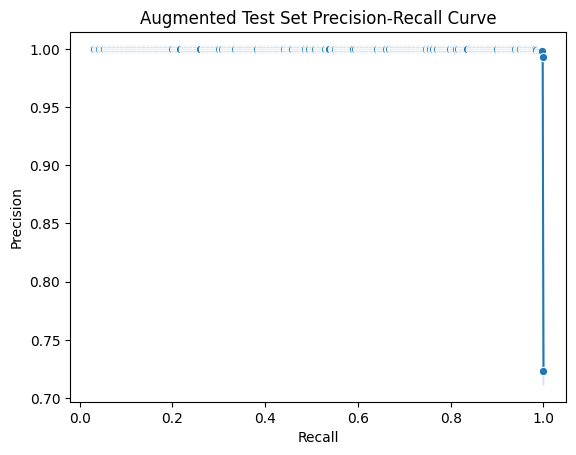

In [36]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Plot a ROC Curve for our Gold Labeled Data

We need to see the ROC Curve for our gold labeled data as well. We care more about performance on this data.

In [37]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(sbert_match, axis=1)

In [38]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.9497949458565346
Best F1 Score: 0.8536585365853658
AUC-ROC: 0.8481338481338481


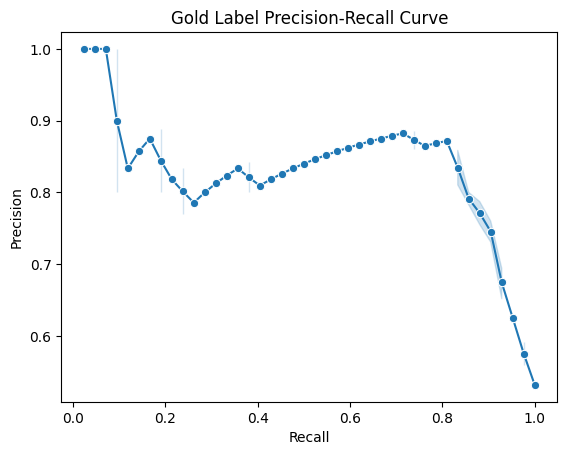

In [39]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

### Debugging Errors on our Gold Labels

Let's evaluate the data using our `gold_label_report` function with the best F1 score. Then we can view the errors and figure out where our model is failing.

In [40]:
raw_df, grouped_df = gold_label_report(
    gold_df,
    [
        sbert_match_binary,
    ],
    threshold=best_threshold
)

#### Label Description Group Analysis

You can see the types of address pairs we are failing on. This can guide our data augmentation / programmatic labeling work at a high level.

In [41]:
grouped_df.head(40)

,sbert_match_binary_acc
Description,
Abbreviated street type for same address should match,1.000000
Abbreviated vs. full street names for same address should match,1.000000
Addition of parenthetical details for same address should match,1.000000
Addresses that match are often missing countries,1.000000
Adjacent or nearby building numbers means different address,0.000000
Close numerical variants are different addresses,0.000000
Common misspellings for same address should match,1.000000
Common typographical errors in same address should match,1.000000
Completely different addresses that don't match,0.000000


In [42]:
grouped_df["sbert_match_binary_acc"].sort_values().head(40)

Description
Different street name endings means different address                                     0.000000
Similar building names can be different addresses                                         0.000000
Similar but different street numbers                                                      0.000000
Different units in a building means different address                                     0.000000
Different unit numbers means different address                                            0.000000
Similar cities in different states, postal codes or countries means different address     0.000000
Different street suffixes means different address                                         0.000000
Punctuation or not in abbreviations for same address should match                         0.000000
Different states means different address                                                  0.000000
Different postal codes means different address                                            0.00000

#### What it Got Right ...

In [43]:
# Truthiness analysis
correct_df = raw_df[raw_df["sbert_match_binary_correct"]].reset_index()
print(f"Number correct: {len(correct_df):,}")

correct_df.head(20)

Number correct: 67


,index,Description,Address1,Address2,Label,sbert_match_binary,sbert_match_binary_correct
0,0,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,1,True
1,1,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,1,True
2,2,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,1,True
3,3,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,1,True
4,5,Numerical variations for same address should m...,"Third Ave, New York, NY","3rd Avenue, New York, New York",1,1,True
5,6,Variant format of same address should match,"350 Fifth Avenue, New York, NY 10118","Empire State Bldg, 350 5th Ave, NY, NY 10118",1,1,True
6,9,Variant formats of same address should match,上海市黄浦区南京东路318号,上海黄浦南京东路318号,1,1,True
7,10,Variant formats of same address should match,Shànghǎi Shì Huángpǔ Qū Nánjīng Dōng Lù 318 Hào,Shànghǎi Huángpǔ Nánjīng Dōng Lù 318 Hào,1,1,True
8,11,Formal and localized format of same address sh...,"B-14, Connaught Place, New Delhi, Delhi 110001...","B-14, CP, ND, DL 110001",1,1,True
9,12,Different character sets for same address shou...,"16, MG Road, Bangalore, Karnataka 560001, India","16, एमजी रोड, बैंगलोर, कर्नाटक 560001",1,1,True


In [44]:
# Error analysis
wrong_df = raw_df[raw_df["sbert_match_binary_correct"] == False].reset_index()
print(f"Number wrong: {len(wrong_df):,}")

wrong_df.head(20)

Number wrong: 12


,index,Description,Address1,Address2,Label,sbert_match_binary,sbert_match_binary_correct
0,4,Incomplete address vs full address may match,"1020 SW 2nd Ave, Portland","1020 SW 2nd Ave, Portland, OR 97204",1,0,False
1,7,Variant format of same address should match,"Çırağan Caddesi No: 32, 34349 Beşiktaş, Istanb...","Ciragan Palace Hotel, Ciragan Street 32, Besik...",1,0,False
2,8,Different character sets for same address shou...,北京市朝阳区建国路88号,Běijīng Shì Cháoyáng Qū Jiànguó Lù 88 Hào,1,0,False
3,16,Different languages for same address should match,北京市东城区东长安街16号,"16 Dongchang'an St, Dongcheng, Beijing, China",1,0,False
4,18,Same address with and without country should m...,"3413 Sean Way, Lawrenceville, GA 30044, U.S.A.","3413 Sean Way, Lawrenceville, Georgia, 30044",1,0,False
5,37,Punctuation or not in abbreviations for same a...,"10350 NE 12th St, Bellevue, WA 98003","10350 N.E. 12th St., Bellevue, WA 98003",1,0,False
6,40,Missing country in one record can match,"3413 Sean Way, Lawrenceville, GA 30044","3413 Sean Way, Lawrenceville, GA 30044, USA",1,0,False
7,43,Different street names means different address,"101 Market Square, Seattle, WA 98039","101 Davis Place, Seattle, WA 98039",0,1,False
8,53,Similar road names can be different addresses,北京市朝阳区朝阳门外大街6号,北京市朝阳区朝阳门内大街6号,0,1,False
9,54,Similar road names can be different addresses,Běijīng Shì Cháoyáng Qū Cháoyángmén Wài Dàjiē ...,Běijīng Shì Cháoyáng Qū Cháoyángmén Nèi Dàjiē ...,0,1,False


In [45]:
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9098839301532112